In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import xarray as xr

rng = np.random.default_rng()

In [2]:
data = pd.DataFrame({
    'var1': rng.uniform(size=1000),
    'var2': rng.uniform(size=1000),
})
x = data[['var1','var2']]
y = 3 + data.var1 - .7 * data.var2 + rng.normal(loc=0, scale=1.3, size=1000)

with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', data)
    idata = pm.sample(3000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x[1], x[0], Intercept]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 8 seconds.


In [3]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [4]:
new_data = xr.DataArray(
    rng.uniform(1, 1.5, size=[5,2]),
    dims=["pred_id", "var"],
    coords={"var": ["x[0]", "x[1]"]} 
# coords is optional, done to use label based index afterwards
)
pred_mean = (
    idata.posterior["Intercept"] +
    new_data.sel(var="x[0]") * idata.posterior["x[0]"] +
    new_data.sel(var="x[1]") * idata.posterior["x[1]"]
)

In [5]:
predictions = xr.apply_ufunc(lambda mu, sd: rng.normal(mu, sd), pred_mean, idata.posterior["sd"])

`xr.apply_ufunc` broadcasts and keeps the labels (dimensions and coord values) when using a numpy function on xarray objects. 

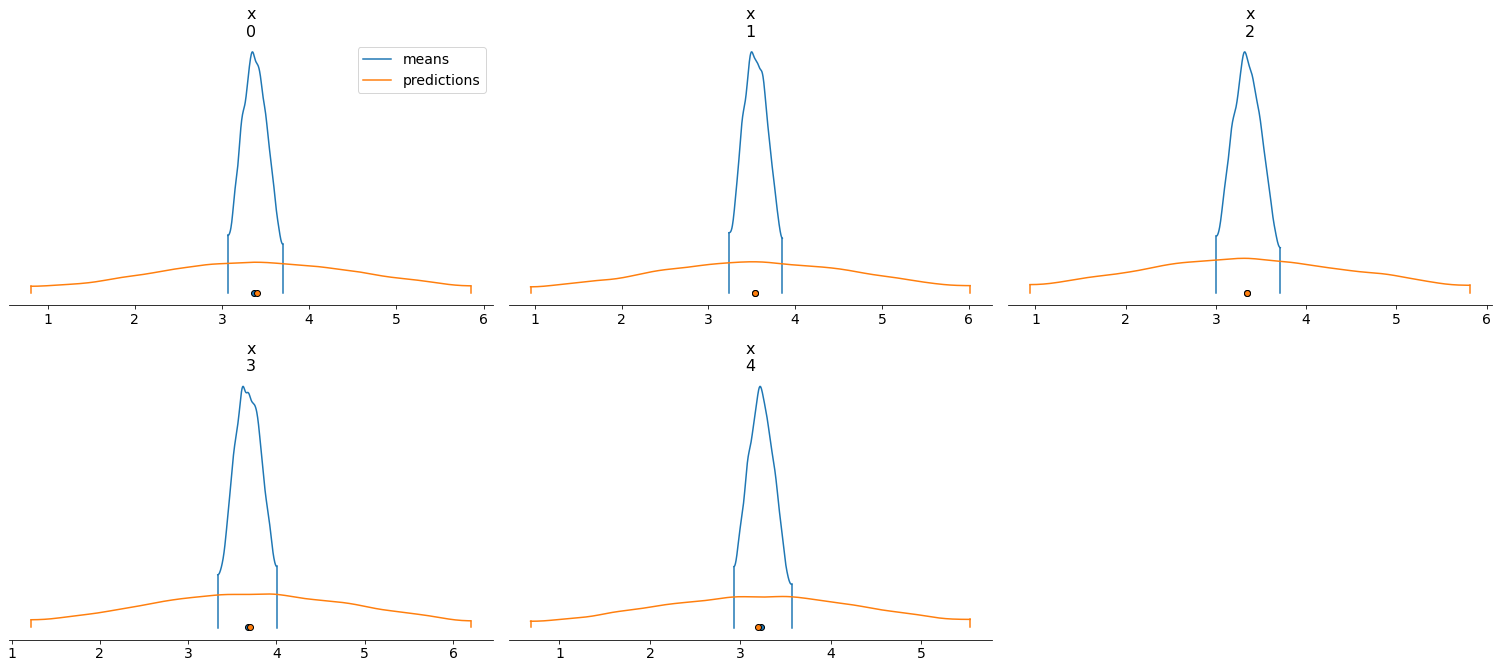

In [6]:
az.plot_density((pred_mean, predictions), data_labels=("means", "predictions"));